In [6]:
%matplotlib inline
import os
import re

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.scripts.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/lfs1/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.scripts.g1_threshold' from '/lfs1/home/jackyu/climatools/climatools/scripts/g1_threshold.py'>

In [7]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (include \s+ '.*\.pro')
    '''


def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [8]:
analysis = scripts.Analysis()

In [9]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = os.path.join('/lfs1/home/jackyu/radiation',
                          'crd/LW/examples',
                          'separate_g_groups',
                          'study__lblnew_g1_threshold',
                          'h2o',
                          'band08_wn_1380_1900',
                          'ng_8',
                          'g_ascending_k_descending',
                          'refPTs_P_1_T_250__P_10_T_250__P_500_T_250',
                          'ng_refs_3__2__3',
                          'getabsth_auto__auto__auto',
                          'absth_dlogN_uniform__dlogN_uniform__dlogN_uniform',
                          'wgt_.55_.55_.85__.85_.85__0_.3_.55',
                          'wgt_flux_2',
                          'wgt_k_1',
                          'crd_a140ac7',
                          'atmpro_mls')
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.load_data()

In [10]:
crdx_wgt = analysis.model('wgt')
crdx_wgt.type_model = 'crd'
crdx_wgt.rundir = os.path.join('/lfs1/home/jackyu/radiation',
                          'crd/LW/examples',
                          'separate_g_groups',
                          'study__lblnew_g1_threshold',
                          'h2o',
                          'band08_wn_1380_1900',
                          'ng_8',
                          'g_ascending_k_descending',
                          'refPTs_P_1_T_250__P_10_T_250__P_500_T_250',
                          'ng_refs_3__2__3',
                          'getabsth_auto__auto__auto',
                          'absth_dlogN_uniform__dlogN_uniform__dlogN_uniform',
                          'wgt_.55_.55_.85__.85_.85__0_.3_.55',
                          'wgt_flux_2',
                          'wgt_k_1',
                          'crd_a140ac7',
                          'atmpro_mls')
crdx_wgt.fpath_flux = 'output_xfluxg.dat'
crdx_wgt.fpath_coolr = 'output_xcoolrg.dat'
crdx_wgt.linestyle = '--'
crdx_wgt.load_data()

In [11]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [12]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [13]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [14]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [15]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, innames())))

vstar = 1380

nband = 520

nv = 200

dv = 0.005

tsfc = 294.0

ng = 8

nref = 3

p_refs = (/ 1,  10, 500 /)

t_refs = (/ 250, 250, 250 /)

ng_refs = (/ 3,   2,   3 /)

data wgt
     &     /.55, .55, .85,
     &     .85, .85,
     &     0, .3, .55/

option_wgt_flux = 2

option_wgt_k = 1

option_klin = 0

klin = 6.375563e-24

include 'mls75.pro'


In [16]:
fig.display_hrefanchor()

In [17]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [18]:
table_dgdgs.display_hrefanchor()

In [19]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [20]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [21]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

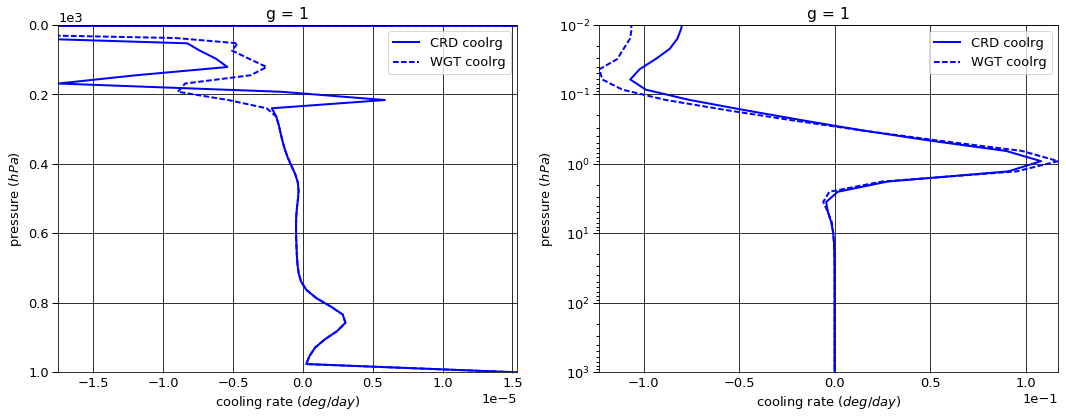

# Figure: cooling rate g-group 2

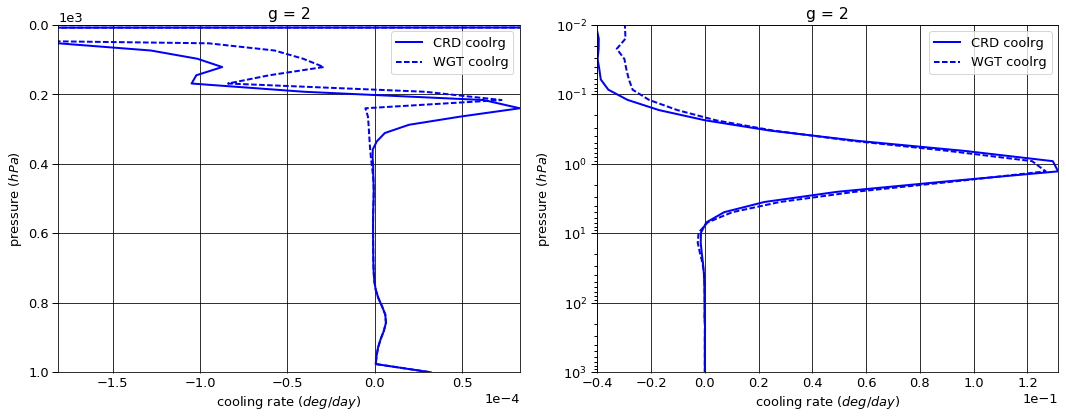

# Figure: cooling rate g-group 3

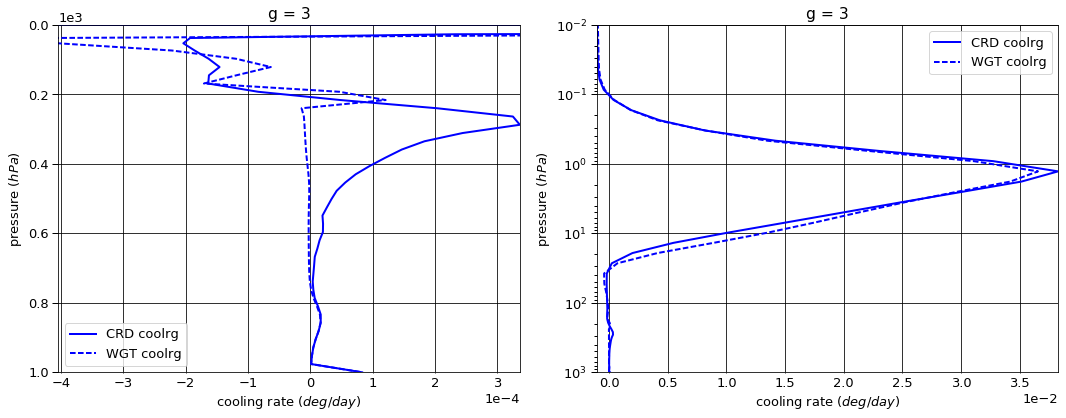

# Figure: cooling rate g-group 4

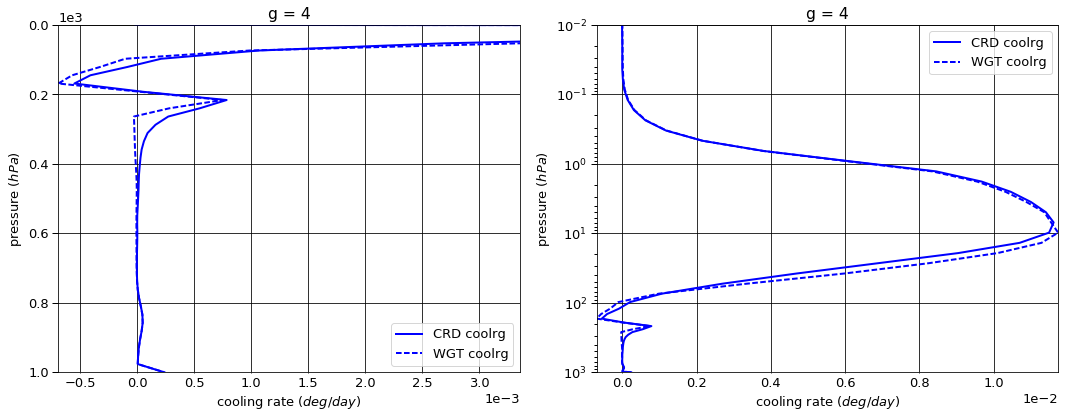

# Figure: cooling rate g-group 5

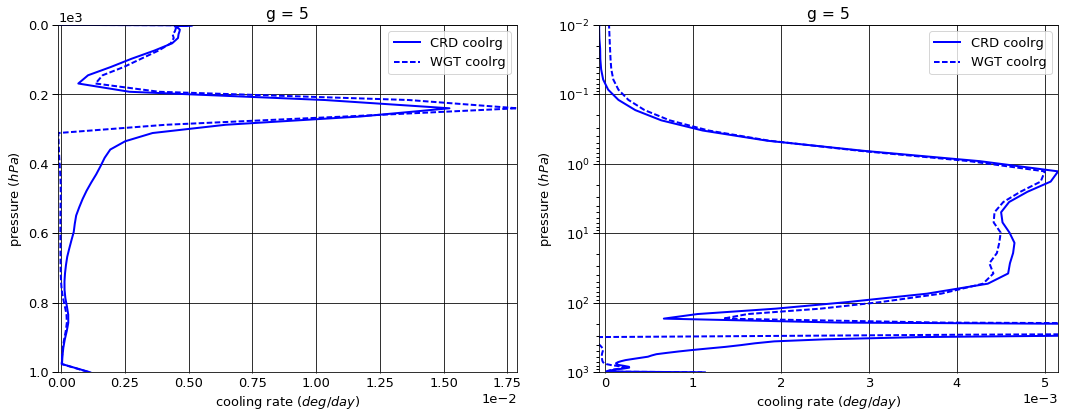

# Figure: cooling rate g-group 6

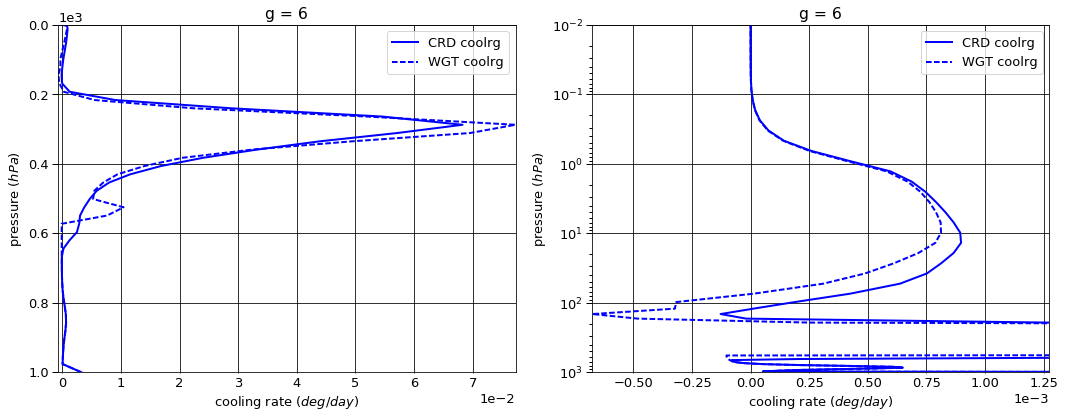

# Figure: cooling rate g-group 7

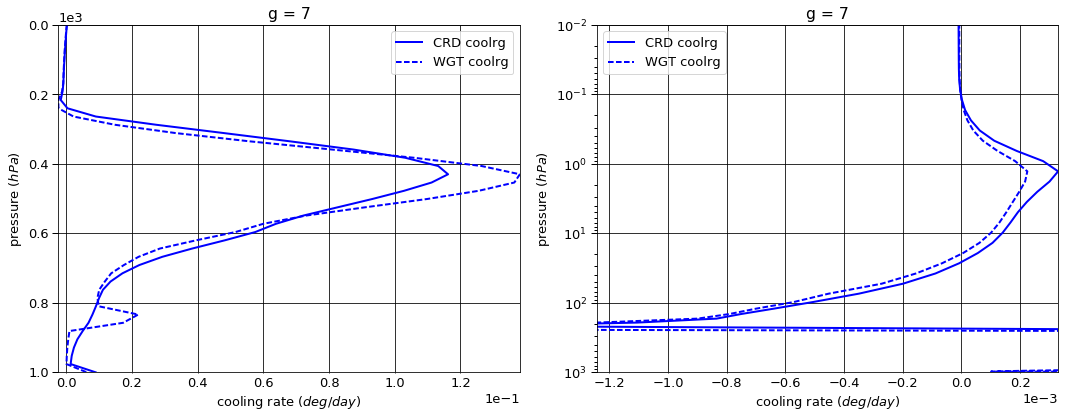

# Figure: cooling rate g-group 8

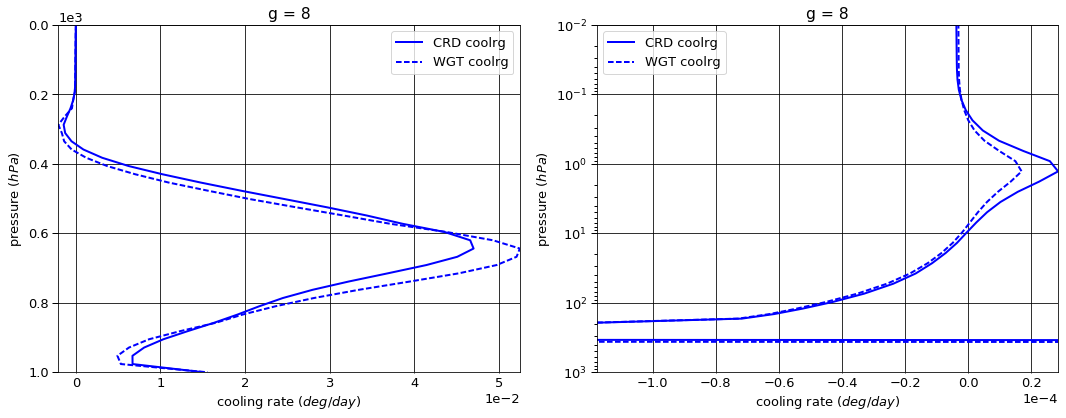

# Figure: cooling rate g-group total

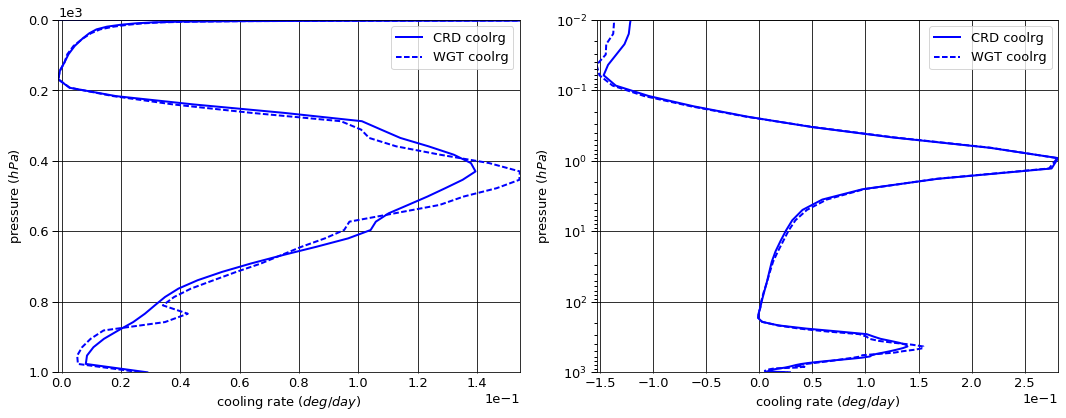

In [22]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [23]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg     fnetg
g pressure level                                
1 0.0      1      -0.009683   0.000000 -0.009683
  1013.0   76     -0.036921   0.036878 -0.000043
2 0.0      1      -0.025937   0.000000 -0.025937
  1013.0   76     -0.077381   0.077291 -0.000090
3 0.0      1      -0.033251   0.000000 -0.033251
  1013.0   76     -0.199909   0.199676 -0.000233
4 0.0      1      -0.055395   0.000000 -0.055395
  1013.0   76     -0.573851   0.573184 -0.000667
5 0.0      1      -0.257622   0.000000 -0.257622
  1013.0   76     -2.665340   2.662164 -0.003176
6 0.0      1      -1.105884   0.000000 -1.105884
  1013.0   76     -7.863826   7.854669 -0.009157
7 0.0      1      -3.930746   0.000000 -3.930746
  1013.0   76    -15.213339  15.189711 -0.023628
8 0.0      1      -1.856464   0.000000 -1.856464
  1013.0   76     -4.099049   4.043207 -0.055842


WGT


flug       fldg     fnetg
g pressure level                                
1 0.0      1      -0.009460   0.000000 -0.009460
  1013.0   76     -0.036921   0.036878 -0.000043
2 0.0      1      -0.026925   0.000000 -0.026925
  1013.0   76     -0.077381   0.077291 -0.000090
3 0.0      1      -0.033499   0.000000 -0.033499
  1013.0   76     -0.199909   0.199676 -0.000233
4 0.0      1      -0.055117   0.000000 -0.055117
  1013.0   76     -0.573851   0.573184 -0.000667
5 0.0      1      -0.216300   0.000000 -0.216300
  1013.0   76     -2.665340   2.662243 -0.003098
6 0.0      1      -1.118637   0.000000 -1.118637
  1013.0   76     -7.863826   7.854669 -0.009157
7 0.0      1      -3.976676   0.000000 -3.976676
  1013.0   76    -15.213339  15.195753 -0.017586
8 0.0      1      -1.886131   0.000000 -1.886131
  1013.0   76     -4.099049   4.051292 -0.047757


WGT - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.000223  0.000000  0.000223
  1013.0   76     0.000000  0.000000  0.000000
2 0.0      1     -0.000987  0.000000 -0.000987
  1013.0   76     0.000000  0.000000  0.000000
3 0.0      1     -0.000249  0.000000 -0.000249
  1013.0   76     0.000000  0.000000  0.000000
4 0.0      1      0.000277  0.000000  0.000277
  1013.0   76     0.000000  0.000000  0.000000
5 0.0      1      0.041322  0.000000  0.041322
  1013.0   76     0.000000  0.000078  0.000078
6 0.0      1     -0.012752  0.000000 -0.012752
  1013.0   76     0.000000  0.000000  0.000000
7 0.0      1     -0.045930  0.000000 -0.045930
  1013.0   76     0.000000  0.006042  0.006042
8 0.0      1     -0.029667  0.000000 -0.029667
  1013.0   76     0.000000  0.008085  0.008085

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1     -9.371736e-02
  1001.112500 75     1.532814e-05
2 0.000312    1     -4.112872e-02
  1001.112500 75     3.199507e-05
3 0.000312    1     -1.214742e-03
  1001.112500 75     8.315173e-05
4 0.000312    1     -1.565461e-05
  1001.112500 75     2.378141e-04
5 0.000312    1     -1.067632e-04
  1001.112500 75     1.136137e-03
6 0.000312    1     -9.283352e-07
  1001.112500 75     3.265732e-03
7 0.000312    1     -1.084338e-05
  1001.112500 75     8.980954e-03
8 0.000312    1     -3.975545e-06
  1001.112500 75     1.514639e-02


WGT


coolrg
g pressure    layer              
1 0.000312    1     -1.227254e-01
  1001.112500 75     1.532814e-05
2 0.000312    1     -3.098470e-02
  1001.112500 75     3.199507e-05
3 0.000312    1     -1.097460e-03
  1001.112500 75     8.305280e-05
4 0.000312    1     -7.680323e-06
  1001.112500 75     2.378141e-04
5 0.000312    1      1.660867e-05
  1001.112500 75     1.104751e-03
6 0.000312    1     -7.645740e-07
  1001.112500 75     3.265732e-03
7 0.000312    1     -8.071988e-06
  1001.112500 75     6.272430e-03
8 0.000312    1     -3.252828e-06
  1001.112500 75     1.558010e-02


WGT - CRD


coolrg
g pressure    layer              
1 0.000312    1     -2.900808e-02
  1001.112500 75     0.000000e+00
2 0.000312    1      1.014402e-02
  1001.112500 75     0.000000e+00
3 0.000312    1      1.172820e-04
  1001.112500 75    -9.893000e-08
4 0.000312    1      7.974286e-06
  1001.112500 75     0.000000e+00
5 0.000312    1      1.233719e-04
  1001.112500 75    -3.138530e-05
6 0.000312    1      1.637612e-07
  1001.112500 75     0.000000e+00
7 0.000312    1      2.771391e-06
  1001.112500 75    -2.708524e-03
8 0.000312    1      7.227166e-07
  1001.112500 75     4.337050e-04

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-7.274982,0.000000,-7.274982
1013.0,76,-30.729616,30.636781,-0.092836



WGT


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-7.322745,0.000000,-7.322745
1013.0,76,-30.729616,30.650986,-0.078631



WGT - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.047763,0.000000,-0.047763
1013.0,76,0.000000,0.014205,0.014205


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.136199
1001.112500,75,0.028898



WGT


,,coolrg
pressure,layer,
0.000312,1,-0.154811
1001.112500,75,0.026591



WGT - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.018612
1001.112500,75,-0.002306


In [24]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.001154,0.001196
2,0.002433,0.002525
3,0.006375,0.006475
4,0.017817,0.018636
5,0.083269,0.086563
6,0.248308,0.254744
7,0.479058,0.498801
8,0.161587,0.131059


In [25]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,4.262964e-18
2,2.786366e-19
3,1.821229e-20
4,1.179072e-20
5,7.724450e-22
6,2.503686e-21
7,1.649401e-22
8,1.086608e-23


In [26]:
def spreadsheet():
    ng = crd.data['dgdgs'].dims['g']
    ng_refs = [3, 2, 3]
    p_refs = [1, 10, 500]
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [27]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet())

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,4.262964e-18,NaN,0.001154,0.001196,0.001154,0.001196,1.0
2,2.786366e-19,0.065362,0.002433,0.002525,0.003587,0.003721,1.0
3,1.821229e-20,0.065362,0.006375,0.006475,0.009962,0.010196,1.0
4,1.179072e-20,0.647404,0.017817,0.018636,0.027779,0.028832,10.0
5,7.724450e-22,0.065513,0.083269,0.086563,0.111048,0.115395,10.0
6,2.503686e-21,3.241249,0.248308,0.254744,0.359356,0.370140,500.0
7,1.649401e-22,0.065879,0.479058,0.498801,0.838413,0.868941,500.0
8,1.086608e-23,0.065879,0.161587,0.131059,1.000000,1.000000,500.0


In [28]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [29]:
pd.set_option('display.max_rows', None)
display.display(
    pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1],
                sep=r'\s+')
    )
pd.reset_option('display.max_rows')

pressure       absmean    absmeanlog      ratio
layer g                                                    
1     1     0.000312  1.544128e-17  8.154182e-18   1.893664
      2     0.000312  9.051800e-19  4.269360e-19   2.120177
      3     0.000312  2.341567e-20  1.030227e-20   2.272865
      4     0.000312  3.342039e-22  2.443357e-22   1.367807
      5     0.000312  2.347633e-22  6.661446e-23   3.524209
      6     0.000312  1.229143e-24  1.182990e-24   1.039014
      7     0.000312  2.607852e-24  1.293763e-24   2.015710
      8     0.000312  1.834798e-24  1.967118e-25   9.327339
2     1     0.000750  1.544103e-17  8.162416e-18   1.891724
      2     0.000750  9.077410e-19  4.281419e-19   2.120187
      3     0.000750  2.352210e-20  1.034905e-20   2.272875
      4     0.000750  3.374256e-22  2.472149e-22   1.364908
      5     0.000750  2.353279e-22  6.686658e-23   3.519366
      6     0.000750  1.243178e-24  1.196790e-24   1.038760
      7     0.000750  2.615991e-24  1.298243e-24   2.015024
      8     0.000750  1.836806e-24  1.972604e-25   9.311584
3     1     0.001052  1.544062e-17  8.179797e-18   1.887654
      2     0.001052  9.131350e-19  4.306432e-19   2.120398
      3     0.001052  2.373258e-20  1.042857e-20   2.275727
      4     0.001052  3.416377e-22  2.507501e-22   1.362463
      5     0.001052  2.363720e-22  6.722692e-23   3.516032
      6     0.001052  1.260120e-24  1.213259e-24   1.038624
      7     0.001052  2.632001e-24  1.306459e-24   2.014607
      8     0.001052  1.840982e-24  1.982980e-25   9.283914
4     1     0.001476  1.544000e-17  8.198087e-18   1.883367
      2     0.001476  9.188653e-19  4.333080e-19   2.120582
      3     0.001476  2.396043e-20  1.051753e-20   2.278142
      4     0.001476  3.465806e-22  2.549772e-22   1.359261
      5     0.001476  2.375184e-22  6.763848e-23   3.511587
      6     0.001476  1.280368e-24  1.233001e-24   1.038417
      7     0.001476  2.649378e-24  1.315468e-24   2.014019
      8     0.001476  1.845511e-24  1.994229e-25   9.254261
5     1     0.002070  1.543917e-17  8.216282e-18   1.879094
      2     0.002070  9.246262e-19  4.359988e-19   2.120708
      3     0.002070  2.419537e-20  1.061360e-20   2.279657
      4     0.002070  3.522942e-22  2.599772e-22   1.355097
      5     0.002070  2.387249e-22  6.809934e-23   3.505540
      6     0.002070  1.304331e-24  1.256448e-24   1.038110
      7     0.002070  2.667358e-24  1.324946e-24   2.013182
      8     0.002070  1.850175e-24  2.005886e-25   9.223729
6     1     0.002904  1.543809e-17  8.234364e-18   1.874838
      2     0.002904  9.304178e-19  4.387202e-19   2.120754
      3     0.002904  2.443906e-20  1.071888e-20   2.280002
      4     0.002904  3.590668e-22  2.660365e-22   1.349690
      5     0.002904  2.400089e-22  6.862858e-23   3.497215
      6     0.002904  1.333427e-24  1.285021e-24   1.037669
      7     0.002904  2.686084e-24  1.335036e-24   2.011995
      8     0.002904  1.854986e-24  2.018084e-25   9.191819
7     1     0.004074  1.543675e-17  8.252334e-18   1.870592
      2     0.004074  9.362471e-19  4.414817e-19   2.120693
      3     0.004074  2.469410e-20  1.083692e-20   2.278701
      4     0.004074  3.673065e-22  2.735673e-22   1.342655
      5     0.004074  2.413959e-22  6.925328e-23   3.485696
      6     0.004074  1.369664e-24  1.320725e-24   1.037054
      7     0.004074  2.705779e-24  1.345952e-24   2.010308
      8     0.004074  1.859970e-24  2.031026e-25   9.157786
8     1     0.005714  1.543509e-17  8.270194e-18   1.866352
      2     0.005714  9.421244e-19  4.442971e-19   2.120483
      3     0.005714  2.496414e-20  1.097273e-20   2.275108
      4     0.005714  3.775855e-22  2.831447e-22   1.333543
      5     0.005714  2.429215e-22  7.001159e-23   3.469733
      6     0.005714  1.415855e-24  1.366374e-24   1.036213
      7     0.005714  2.726751e-24  1.357998e-24   2.007919
      8     0.005714  1.865161e-24  2.045000e-25   9.120593
9     1     0.008015  1.543305e-17  8.287948e-18   1

# Histogram of wavenumbers in g-group 1

In [30]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [31]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
